# Divergence_RSI Reversal - Strategy - Backtesting 

### Import Library

In [30]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [31]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [32]:
data = dataset.copy()

In [33]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [34]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [53]:
def cal_signal(r):
    signal = ''
    if r['RSI_s1'] > r['RSI_s2'] < 30 and r['Low_s1'] < r['min_5'] and r['Close'] > r['Open']:
        signal = 'long'
    elif r['RSI_s1'] < r['RSI_s2'] > 70 and r['High_s1'] > r['max_5'] and r['Close'] < r['Open']:
        signal = 'short'
    return signal

def prepare_data(df):
    df['Low_s1'] = df['Low'].shift(1)
    df['min_5'] = df['Low'].shift(2).rolling(5).min()
    df['High_s1'] = df['High'].shift(1)
    df['max_5'] = df['High'].shift(2).rolling(5).max()
    df['RSI'] = ta.rsi(df["Close"], length=14)
    df['RSI_s1'] = df['RSI'].shift(1)
    df['RSI_s2'] = df['RSI'].shift(2)
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    return df

In [54]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [55]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 3500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        if self.position:
            if self.position.is_long and signal == 'short' or self.position.is_short and signal == 'long':
                self.position.close()
            return 
        
        if signal == 'long':
            low_price = self.data.Low[-2]
            buy_price = close_price
            sl = low_price - 0.1
            tp = buy_price + self.reward_on_risk * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            high_price = self.data.High[-2]
            sell_price = close_price
            sl = high_price + 0.1
            tp = sell_price - self.reward_on_risk * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

In [56]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [57]:
stats

Start                     2020-11-03 10:05:00
End                       2025-02-25 14:45:00
Duration                   1575 days 04:40:00
Exposure Time [%]                    8.600639
Equity Final [$]                   3443.43395
Equity Peak [$]                    3511.79378
Return [%]                          -1.616173
Buy & Hold Return [%]                49.72473
Return (Ann.) [%]                   -0.381227
Volatility (Ann.) [%]                1.853408
Sharpe Ratio                         -0.20569
Sortino Ratio                       -0.336168
Calmar Ratio                        -0.112831
Max. Drawdown [%]                   -3.378747
Avg. Drawdown [%]                   -0.624211
Max. Drawdown Duration     1020 days 03:25:00
Avg. Drawdown Duration      130 days 14:45:00
# Trades                                  443
Win Rate [%]                        32.054176
Best Trade [%]                       3.097546
Worst Trade [%]                     -2.028556
Avg. Trade [%]                    

In [58]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,65,80,912.92604,914.7,-1.77396,-0.001943,2020-11-04 11:15:00,2020-11-04 13:55:00,None,0 days 02:40:00
1,1,326,334,919.27570,917.8,-1.47570,-0.001605,2020-11-11 13:10:00,2020-11-11 13:50:00,None,0 days 00:40:00
2,1,337,338,916.77495,913.9,-2.87495,-0.003136,2020-11-11 14:05:00,2020-11-11 14:10:00,None,0 days 00:05:00
3,1,341,342,919.77585,922.0,2.22415,0.002418,2020-11-11 14:25:00,2020-11-11 14:30:00,None,0 days 00:05:00
4,-1,428,435,930.72070,931.9,-1.17930,-0.001267,2020-11-13 13:20:00,2020-11-13 13:55:00,None,0 days 00:35:00
...,...,...,...,...,...,...,...,...,...,...,...
438,-1,54016,54023,1333.39986,1335.6,-2.20014,-0.001650,2025-02-05 09:30:00,2025-02-05 10:05:00,None,0 days 00:35:00
439,1,54174,54197,1328.29837,1336.3,8.00163,0.006024,2025-02-10 09:55:00,2025-02-10 13:15:00,None,0 days 03:20:00
440,-1,54270,54278,1339.19812,1341.5,-2.30188,-0.001719,2025-02-12 09:25:00,2025-02-12 10:05:00,None,0 days 00:40:00
441,1,54473,54484,1334.00008,1340.2,6.19992,0.004648,2025-02-18 09:20:00,2025-02-18 10:15:00,None,0 days 00:55:00


In [59]:
# bt.plot()

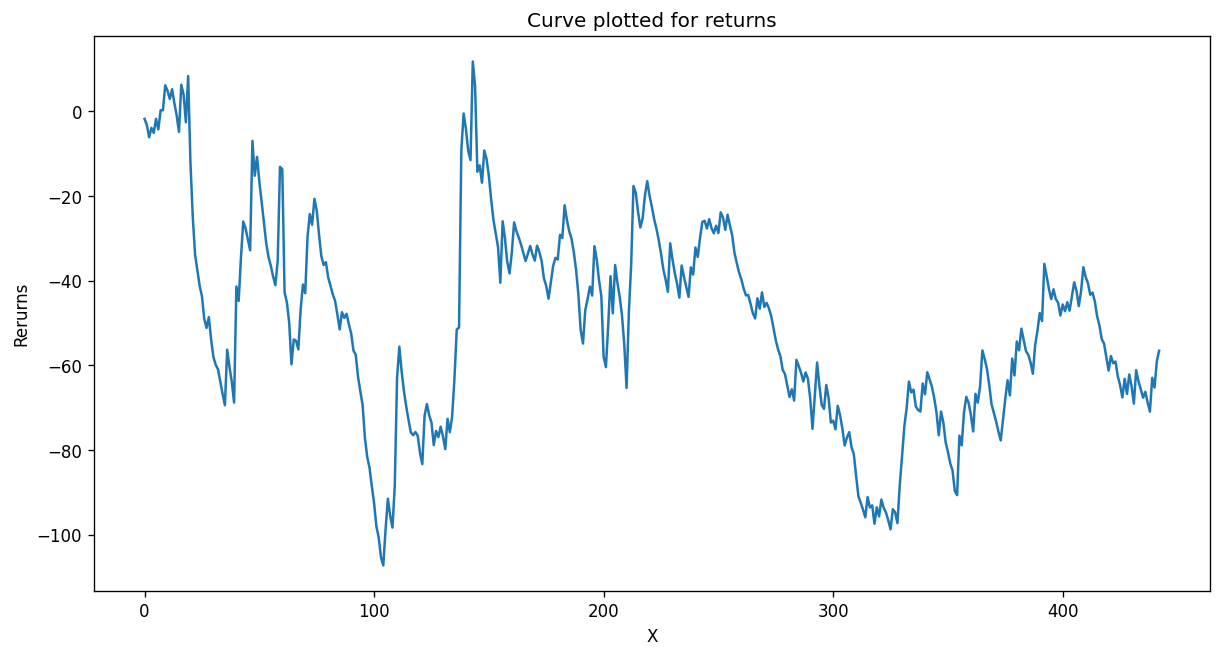

In [60]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()